In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

!pip install catboost
from catboost import CatBoostClassifier

from scipy.stats import mannwhitneyu, ttest_ind

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.8 MB/s eta 0:00:00


# Обработка данных

Загружаем данные полученый на этапе парсинга

In [4]:
df = pd.read_csv('df-3.csv')
df = df.drop(columns='Unnamed: 0')

Посмотрим как выглядят данные


> Видим что среди полученных данных много мусора. Так же заметно, что есть редко встречающиеся темы.



In [5]:
counts = df.groupby(df.iloc[:, 1]).size().reset_index(name='Количество строк')
counts_sorted = counts.sort_values(by=counts.columns[1])
counts_sorted

,Theme,Количество строк
164,Открытая олимпиада НОЦ ВолНЦ РАН — 2020,1
33,\n6.75\nСредняя: 6.8 (8 оценок)\n\n,1
34,\n6.8\nСредняя: 6.8 (5 оценок)\n\n,1
37,\n7\nСредняя: 7 (3 оценок)\n\n,1
38,\n7.33333\nСредняя: 7.3 (3 оценок)\n\n,1
...,...,...
203,математика,80
211,производитель и рынки,118
53,11-й класс,127
0,\n0\nГолосов еще нет\n\n,209


Уберем темы котрые не темы, пропуски и редко встречающиеся темы

In [7]:
theme = pd.read_excel('theme.xlsx')

df = df[df['Theme'].isin(list(theme.theme))]
value_counts = df.iloc[:, 1].value_counts()
df = df[df.iloc[:, 1].isin(value_counts[value_counts > 9].index)]
df.dropna(inplace=True)

Посмотрим на диаграмме что у нас получилось

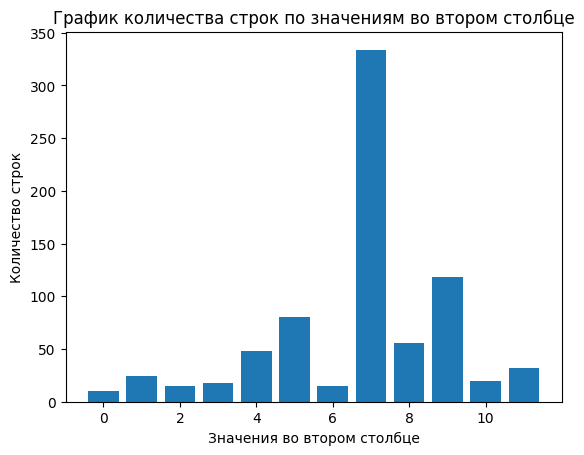

In [11]:
counts = df.groupby(df.iloc[:, 1]).size()

plt.bar(counts.index, counts.values)
plt.xlabel('Значения во втором столбце')
plt.ylabel('Количество строк')
plt.title('График количества строк по значениям во втором столбце')
plt.show()

Займемся энкодингом:

*   Для тем мы проведем лейбл-кодирование
*   Разобъём на тест/трейн
*   Векторизируем тексты

In [8]:
label_encoder = LabelEncoder()

df['Theme'] = label_encoder.fit_transform(df['Theme'])

In [9]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

X_train = train.iloc[:,0]
X_test = test.iloc[:,0]
y_train = train.iloc[:,1:-1]
y_test = test.iloc[:,1:-1]

In [10]:
vectorizer = CountVectorizer(tokenizer=TweetTokenizer().tokenize, analyzer='word')

X = df.iloc[:,0]
y = df.iloc[:,1:]

X = vectorizer.fit_transform(X)

X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Реализация модели

Будем использовать модель кэтбуст от яндекса и переберем гиперпараметры с помощью гридсерч


> Перебор показал наилучшие результаты при гиперпараметрах: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}



In [ ]:
model = CatBoostClassifier()

param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [4, 6, 8],
    'loss_function': ['MultiClass']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

grid_search.fit(X_train, y_train)

print("Наилучшие значения гиперпараметров: ", grid_search.best_params_)
print("Оценка наилучшей модели: ", grid_search.best_score_)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = model.predict(X_test)

# Вычисление метрик качества
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Вывод метрик качества
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Вывод отчета по классификации
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

# Проверки гипотез

Существует стереотип, что задачи по макроэкономике в олимпиатках как правило качественные, в то время как микра больше количественная. На превый взгляд кажется неплохой идеей проверить: а в каком типе задач в среднем больше слов? (типа в качественных обыно много текста) Потом ещё может появиться мысль проверить обратное: являются ли задачи в микро более качественные чем макро?
Для этого:


1.   Проверим гипотезу о том что в среднем кол-во слов в макро больше чем в микро
2.   Проверим гипотезу о том что в среднем в микро цифры встречаются чаще чем в макро



In [13]:
df = pd.read_csv('df-3.csv')
df = df.drop(columns='Unnamed: 0')
df = df[df['Theme'].isin(list(theme.theme))]
value_counts = df.iloc[:, 1].value_counts()
df = df[df.iloc[:, 1].isin(value_counts[value_counts > 9].index)]
df.dropna(inplace=True)

In [16]:
texts_macro = df[df['Theme'] == 'макроэкономика']['Task']
texts_micro = df[df['Theme'] == 'микроэкономика']['Task']

word_count_macro = texts_macro.apply(lambda x: len(x.split()))
word_count_micro = texts_micro.apply(lambda x: len(x.split()))

statistic, p_value = mannwhitneyu(word_count_macro, word_count_micro, alternative='greater')

alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: в текстах с признаком 'макроэкономика' больше слов, чем в текстах с признаком 'микроэкономика'")
else:
    print("Не получаем достаточных доказательств для отвержения нулевой гипотезы")

Не получаем достаточных доказательств для отвержения нулевой гипотезы


In [17]:
digit_count_macro = texts_macro.apply(lambda x: sum(char.isdigit() for char in x))
digit_count_micro = texts_micro.apply(lambda x: sum(char.isdigit() for char in x))

statistic, p_value = ttest_ind(digit_count_macro, digit_count_micro)

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: в текстах с признаком 'макроэкономика' в среднем цифр меньше, чем в текстах с признаком 'микроэкономика'")
else:
    print("Не получаем достаточных доказательств для отвержения нулевой гипотезы")

Отвергаем нулевую гипотезу: в текстах с признаком 'макроэкономика' в среднем цифр меньше, чем в текстах с признаком 'микроэкономика'
